In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np, os
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad

print(torch.cuda.device_count())
cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")
data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


2
NVIDIA A30
(872, 4500, 14) (872,)


# Multivariate Anomaly Detection GAN

Rewrite, because MADGAN use LSTM

In [2]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Memory-efficient MAD-GAN Generator
class MADGeneratorMemoryEfficient(nn.Module):
    def __init__(self, latent_dim=50, hidden_dim=64, num_features=14, seq_len=4500):
        super(MADGeneratorMemoryEfficient, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_features = num_features
        self.seq_len = seq_len
        
        # Single LSTM layer to reduce memory
        self.lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True, dropout=0.1)
        
        # Simplified projection
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, num_features),
            nn.Tanh()
        )
        
    def forward(self, z):
        # Process in chunks to save memory
        chunk_size = 1000  # Process 1000 timesteps at a time
        outputs = []
        
        for i in range(0, self.seq_len, chunk_size):
            end_idx = min(i + chunk_size, self.seq_len)
            z_chunk = z[:, i:end_idx, :]
            
            h_chunk, _ = self.lstm(z_chunk)
            out_chunk = self.fc(h_chunk)
            outputs.append(out_chunk)
            
            # Clear intermediate results
            del h_chunk, z_chunk
            
        return torch.cat(outputs, dim=1)

# Memory-efficient MAD-GAN Discriminator
class MADDiscriminatorMemoryEfficient(nn.Module):
    def __init__(self, num_features=14, hidden_dim=64, seq_len=4500):
        super(MADDiscriminatorMemoryEfficient, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        # Single LSTM layer
        self.lstm = nn.LSTM(num_features, hidden_dim, batch_first=True, dropout=0.1)
        
        # Simple pooling and classification
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        # Process in chunks to save memory
        chunk_size = 1000
        hidden_states = []
        
        for i in range(0, self.seq_len, chunk_size):
            end_idx = min(i + chunk_size, self.seq_len)
            x_chunk = x[:, i:end_idx, :]
            
            h_chunk, _ = self.lstm(x_chunk)
            # Take the last hidden state of each chunk
            hidden_states.append(h_chunk[:, -1, :])
            
            del h_chunk, x_chunk
        
        # Average the hidden states from all chunks
        avg_hidden = torch.stack(hidden_states, dim=1).mean(dim=1)
        out = self.classifier(avg_hidden)
        
        return out

# Memory-efficient training function with gradient accumulation
def train_mad_gan_memory_efficient(normal_data, device, epochs=30, batch_size=2, 
                                 accumulation_steps=8, lr_g=0.0002, lr_d=0.0001):
    """
    Memory-efficient MAD-GAN training with very small batches and gradient accumulation
    """
    print(f"Original data shape: {normal_data.shape}")
    print(f"Data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")
    
    # Normalize data to [-1, 1] range
    data_min = normal_data.min()
    data_max = normal_data.max()
    normalized_data = 2 * (normal_data - data_min) / (data_max - data_min) - 1
    print(f"Normalized data range: [{normalized_data.min():.4f}, {normalized_data.max():.4f}]")
    
    # Model parameters
    latent_dim = 50  # Reduced latent dimension
    hidden_dim = 64  # Reduced hidden dimension
    num_features = normalized_data.shape[-1]
    seq_len = normalized_data.shape[1]
    
    print(f"Model parameters - Latent: {latent_dim}, Hidden: {hidden_dim}, Features: {num_features}, Seq_len: {seq_len}")
    
    # Initialize models
    generator = MADGeneratorMemoryEfficient(latent_dim, hidden_dim, num_features, seq_len).to(device)
    discriminator = MADDiscriminatorMemoryEfficient(num_features, hidden_dim, seq_len).to(device)
    
    # Count parameters
    g_params = sum(p.numel() for p in generator.parameters())
    d_params = sum(p.numel() for p in discriminator.parameters())
    print(f"Generator parameters: {g_params:,}")
    print(f"Discriminator parameters: {d_params:,}")
    
    # Weight initialization
    def weights_init(m):
        if isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # Create dataloader with very small batch size
    dataset = TensorDataset(torch.tensor(normalized_data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print(f"Starting Memory-Efficient MAD-GAN training...")
    print(f"Batch size: {batch_size}, Accumulation steps: {accumulation_steps}")
    print(f"Effective batch size: {batch_size * accumulation_steps}")
    print(f"Learning rates - Generator: {lr_g}, Discriminator: {lr_d}")
    
    # Training history
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        
        # Initialize accumulators
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()
        
        for i, (real_data,) in enumerate(dataloader):
            real_data = real_data.to(device)
            current_batch_size = real_data.size(0)
            
            # Labels
            real_labels = torch.ones(current_batch_size, 1, device=device) * 0.9
            fake_labels = torch.zeros(current_batch_size, 1, device=device) + 0.1
            
            # Train Discriminator
            # Real data
            real_pred = discriminator(real_data)
            d_real_loss = criterion(real_pred, real_labels) / accumulation_steps
            d_real_loss.backward()
            
            # Fake data
            z = torch.randn(current_batch_size, seq_len, latent_dim, device=device)
            with torch.no_grad():
                fake_data = generator(z)
            fake_pred = discriminator(fake_data)
            d_fake_loss = criterion(fake_pred, fake_labels) / accumulation_steps
            d_fake_loss.backward()
            
            d_loss = (d_real_loss + d_fake_loss) * accumulation_steps
            epoch_d_losses.append(d_loss.item())
            
            # Update discriminator every accumulation_steps
            if (i + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
                optimizer_D.step()
                optimizer_D.zero_grad()
            
            # Train Generator less frequently
            if i % (accumulation_steps * 2) == 0:  # Train G every 2*accumulation_steps
                z = torch.randn(current_batch_size, seq_len, latent_dim, device=device)
                fake_data = generator(z)
                fake_pred = discriminator(fake_data)
                
                g_loss = criterion(fake_pred, real_labels) / accumulation_steps
                g_loss.backward()
                
                epoch_g_losses.append(g_loss.item() * accumulation_steps)
                
                if (i + 1) % accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
                    optimizer_G.step()
                    optimizer_G.zero_grad()
            
            # Clear cache periodically
            if i % 10 == 0:
                torch.cuda.empty_cache()
            
            # # Memory monitoring
            # if i % 50 == 0 and torch.cuda.is_available():
            #     memory_used = torch.cuda.memory_allocated(device) / 1024**3
            #     memory_cached = torch.cuda.memory_reserved(device) / 1024**3
            #     print(f"  Batch {i}: Memory used: {memory_used:.2f}GB, Cached: {memory_cached:.2f}GB")
        
        # Calculate average losses
        avg_d_loss = np.mean(epoch_d_losses) if epoch_d_losses else 0
        avg_g_loss = np.mean(epoch_g_losses) if epoch_g_losses else 0
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
        
        # Clear cache at end of epoch
        torch.cuda.empty_cache()
    
    return generator, discriminator, d_losses, g_losses, (data_min, data_max)

# Memory-efficient sample generation
def generate_samples_memory_efficient(generator, num_samples, seq_len, latent_dim, device, data_range):
    """
    Generate samples with very small batches to avoid OOM
    """
    generator.eval()
    data_min, data_max = data_range
    
    generated_batches = []
    batch_size = 1  # Generate one sample at a time
    
    print(f"Generating {num_samples} samples...")
    
    with torch.no_grad():
        for i in range(num_samples):
            if i % 50 == 0:
                print(f"Generated {i}/{num_samples} samples")
                torch.cuda.empty_cache()
            
            z = torch.randn(1, seq_len, latent_dim, device=device)
            sample_generated = generator(z)
            
            # Denormalize from [-1, 1] back to original range
            sample_generated = (sample_generated + 1) / 2 * (data_max - data_min) + data_min
            
            generated_batches.append(sample_generated.cpu())
    
    return torch.cat(generated_batches, dim=0).numpy()

# Multivariate Anomaly Detection GAN Training

Starting memory-efficient MAD-GAN training...
Original data shape: (690, 4500, 14)
Data range: [-3995.8000, 127440.0000]
Normalized data range: [-1.0000, 1.0000]
Model parameters - Latent: 50, Hidden: 64, Features: 14, Seq_len: 4500
Generator parameters: 32,238
Discriminator parameters: 22,593
Starting Memory-Efficient MAD-GAN training...
Batch size: 16, Accumulation steps: 8
Effective batch size: 128
Learning rates - Generator: 0.005, Discriminator: 5e-05
Epoch 1/50 | D Loss: 1.3859 | G Loss: 0.6931
Epoch 2/50 | D Loss: 1.3856 | G Loss: 0.6930
Epoch 3/50 | D Loss: 1.3853 | G Loss: 0.6930
Epoch 4/50 | D Loss: 1.3850 | G Loss: 0.6929
Epoch 5/50 | D Loss: 1.3847 | G Loss: 0.6928
Epoch 6/50 | D Loss: 1.3843 | G Loss: 0.6927
Epoch 7/50 | D Loss: 1.3838 | G Loss: 0.6926
Epoch 8/50 | D Loss: 1.3832 | G Loss: 0.6925
Epoch 9/50 | D Loss: 1.3826 | G Loss: 0.6924
Epoch 10/50 | D Loss: 1.3819 | G Loss: 0.6923
Epoch 11/50 | D Loss: 1.3810 | G Loss: 0.6922
Epoch 12/50 | D Loss: 1.3801 | G Loss: 0.6

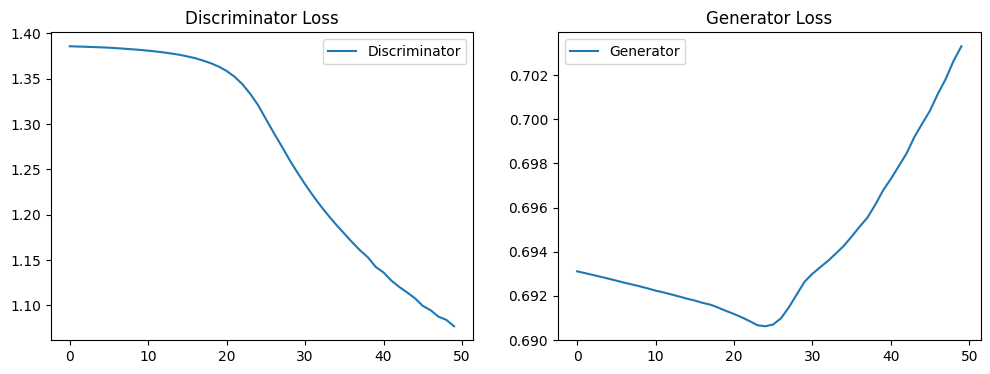

In [4]:
# Clear GPU memory
torch.cuda.empty_cache()

# Memory-efficient training with very small batches
print("Starting memory-efficient MAD-GAN training...")
generator, discriminator, d_history, g_history, data_range = train_mad_gan_memory_efficient(
    normal_data, 
    device, 
    epochs=50,              # Reduced epochs due to slower training
    batch_size=16,           # Very small batch size
    accumulation_steps=8,   # Effective batch size = 16
    lr_g=0.005,           
    lr_d=0.00005
)


# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(d_history, label='Discriminator')
plt.title('Discriminator Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(g_history, label='Generator')
plt.title('Generator Loss')
plt.legend()
plt.show()

# Clear GPU memory after training
torch.cuda.empty_cache()

# Generate and Combine

In [5]:
# Generate synthetic samples with memory-efficient approach
print("Generating synthetic samples...")
num_samples = len(normal_data)
seq_len = normal_data.shape[1]
latent_dim = 50  # Reduced latent dimension

generated_data = generate_samples_memory_efficient(
    generator, num_samples, seq_len, latent_dim, device, data_range
)

print(f"Generated data shape: {generated_data.shape}")


# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(num_samples), normal_label), axis=0)


Generating synthetic samples...
Generating 690 samples...
Generated 0/690 samples
Generated 50/690 samples
Generated 100/690 samples
Generated 150/690 samples
Generated 200/690 samples
Generated 250/690 samples
Generated 300/690 samples
Generated 350/690 samples
Generated 400/690 samples
Generated 450/690 samples
Generated 500/690 samples
Generated 550/690 samples
Generated 600/690 samples
Generated 650/690 samples
Generated data shape: (690, 4500, 14)


# Processing: Mel Spec > Resizing > Feature Extraction

In [6]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [7]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    """
    X_test: shape (n_samples, 1, 4096) - already has channel dimension added
    y_test: shape (n_samples,)
    """
    # X_test already has shape (n_samples, 1, 4096) from your code
    # So we can directly compute reconstruction errors
    test_errors = compute_reconstruction_loss(model, X_test)
    
    # Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(test_errors.min(), test_errors.max(), 100):
        preds = (test_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Predict using best threshold
    test_preds = (test_errors > best_threshold).astype(int)

    # Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


# Preprocessing

In [8]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_normal_data = StandardScaler().fit_transform(combine_data_normal.reshape(-1, combine_data_normal.shape[-1])).reshape(combine_data_normal.shape)
scaled_original_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features_original = process_dataset_multichannel(scaled_original_data)
print("Features shape:", features_original.shape)
features_normal = process_dataset_multichannel(scaled_normal_data)
print("Features shape:", features_normal.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)
Processing 1380 samples with multi-channel approach...
Processed 0/1380 samples
Processed 100/1380 samples
Processed 200/1380 samples
Processed 300/1380 samples
Processed 400/1380 samples
Processed 500/1380 samples
Processed 600/1380 samples
Processed 700/1380 samples
Processed 800/1380 samples
Processed 900/1380 samples
Processed 1000/1380 samples
Processed 1100/1380 samples
Processed 1200/1380 samples
Processed 1300/1380 samples
Features shape: (1380, 4096)


# Cross Validation

Fold 1
Epoch 1/15, Loss: 1.158702
Epoch 2/15, Loss: 0.805989
Epoch 3/15, Loss: 0.566744
Epoch 4/15, Loss: 0.536475
Epoch 5/15, Loss: 0.532481
Epoch 6/15, Loss: 0.531330
Epoch 7/15, Loss: 0.530591
Epoch 8/15, Loss: 0.529999
Epoch 9/15, Loss: 0.529531
Epoch 10/15, Loss: 0.529157
Epoch 11/15, Loss: 0.528851
Epoch 12/15, Loss: 0.528598
Epoch 13/15, Loss: 0.528391
Epoch 14/15, Loss: 0.528214
Epoch 15/15, Loss: 0.528068
Best threshold: 0.5245798573349462, Best F1 Score: 0.38636363636363635


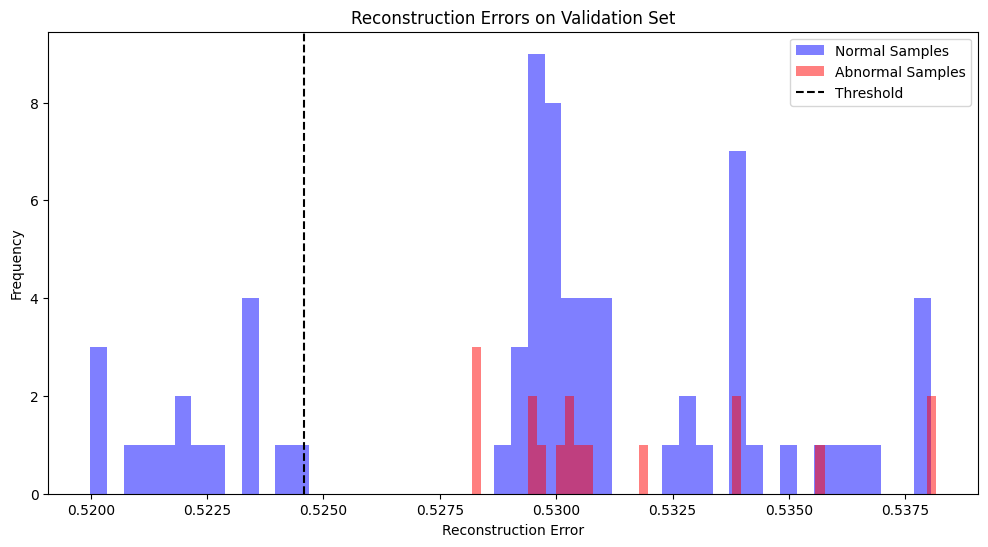

Best Threshold = 0.524783, Best F1 Score = 0.4255
Evaluation on Test Set:
Accuracy = 0.38636363636363635
Precision = 0.2702702702702703
Recall = 1.0
F1 Score = 0.4255319148936171
Confusion Matrix:
 [[14 54]
 [ 0 20]]
Fold 2
Epoch 1/15, Loss: 1.155333
Epoch 2/15, Loss: 0.811081
Epoch 3/15, Loss: 0.569116
Epoch 4/15, Loss: 0.536239
Epoch 5/15, Loss: 0.532068
Epoch 6/15, Loss: 0.530988
Epoch 7/15, Loss: 0.530325
Epoch 8/15, Loss: 0.529798
Epoch 9/15, Loss: 0.529372
Epoch 10/15, Loss: 0.529031
Epoch 11/15, Loss: 0.528748
Epoch 12/15, Loss: 0.528515
Epoch 13/15, Loss: 0.528321
Epoch 14/15, Loss: 0.528152
Epoch 15/15, Loss: 0.528016
Best threshold: 0.5248794609850104, Best F1 Score: 0.45652173913043476


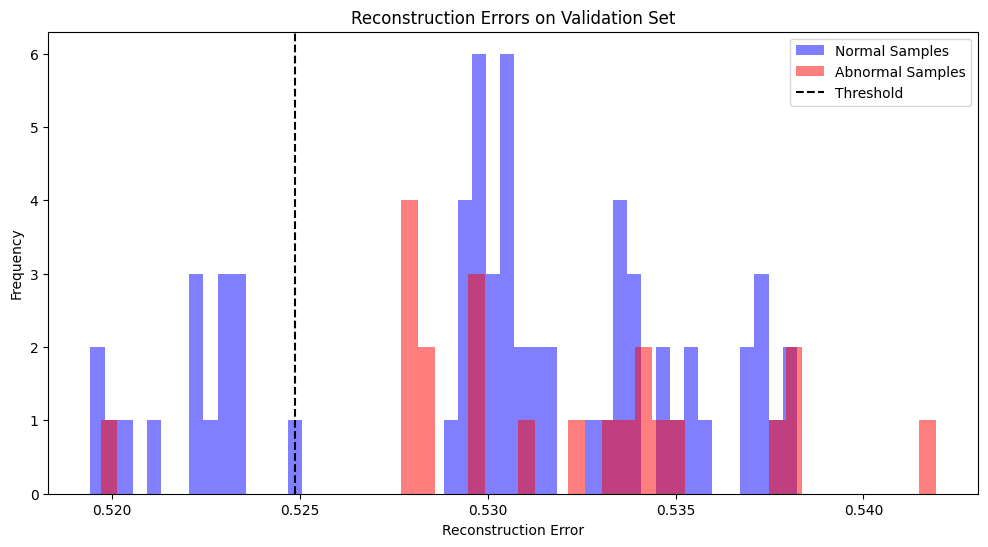

Best Threshold = 0.534717, Best F1 Score = 0.4615
Evaluation on Test Set:
Accuracy = 0.8409090909090909
Precision = 0.5454545454545454
Recall = 0.4
F1 Score = 0.4615384615384615
Confusion Matrix:
 [[68  5]
 [ 9  6]]
Fold 3
Epoch 1/15, Loss: 1.148076
Epoch 2/15, Loss: 0.789553
Epoch 3/15, Loss: 0.566261
Epoch 4/15, Loss: 0.536811
Epoch 5/15, Loss: 0.532538
Epoch 6/15, Loss: 0.531250
Epoch 7/15, Loss: 0.530489
Epoch 8/15, Loss: 0.529920
Epoch 9/15, Loss: 0.529477
Epoch 10/15, Loss: 0.529118
Epoch 11/15, Loss: 0.528835
Epoch 12/15, Loss: 0.528590
Epoch 13/15, Loss: 0.528392
Epoch 14/15, Loss: 0.528220
Epoch 15/15, Loss: 0.528075
Best threshold: 0.5229853235109888, Best F1 Score: 0.37647058823529417


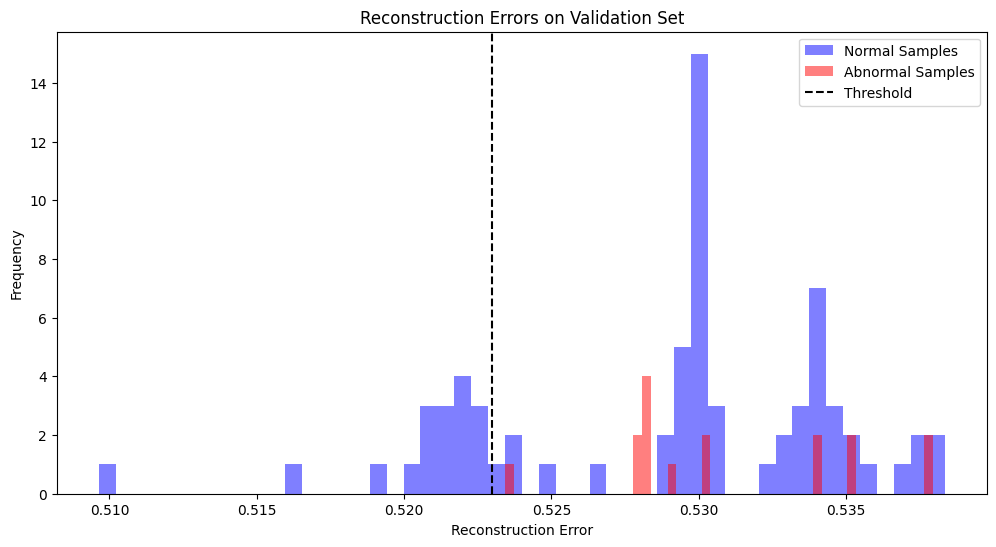

Best Threshold = 0.525356, Best F1 Score = 0.4270
Evaluation on Test Set:
Accuracy = 0.41379310344827586
Precision = 0.2753623188405797
Recall = 0.95
F1 Score = 0.42696629213483145
Confusion Matrix:
 [[17 50]
 [ 1 19]]
Fold 4
Epoch 1/15, Loss: 1.163734
Epoch 2/15, Loss: 0.841083
Epoch 3/15, Loss: 0.572937
Epoch 4/15, Loss: 0.535552
Epoch 5/15, Loss: 0.531686
Epoch 6/15, Loss: 0.530891
Epoch 7/15, Loss: 0.530328
Epoch 8/15, Loss: 0.529834
Epoch 9/15, Loss: 0.529416
Epoch 10/15, Loss: 0.529063
Epoch 11/15, Loss: 0.528780
Epoch 12/15, Loss: 0.528543
Epoch 13/15, Loss: 0.528342
Epoch 14/15, Loss: 0.528170
Epoch 15/15, Loss: 0.528024
Best threshold: 0.5318710743778884, Best F1 Score: 0.6046511627906976


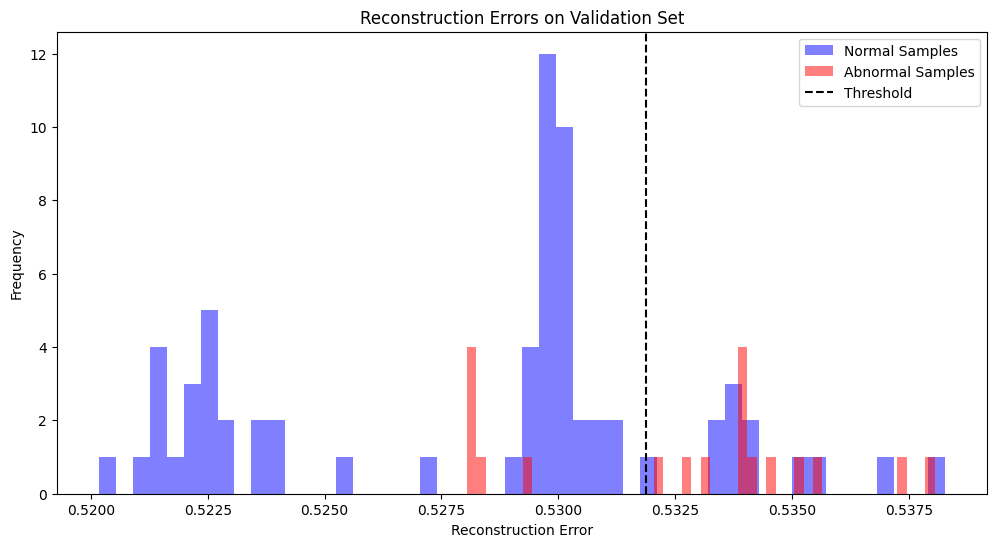

Best Threshold = 0.530334, Best F1 Score = 0.3750
Evaluation on Test Set:
Accuracy = 0.6551724137931034
Precision = 0.2903225806451613
Recall = 0.5294117647058824
F1 Score = 0.375
Confusion Matrix:
 [[48 22]
 [ 8  9]]
Fold 5
Epoch 1/15, Loss: 1.159951
Epoch 2/15, Loss: 0.813549
Epoch 3/15, Loss: 0.567126
Epoch 4/15, Loss: 0.535783
Epoch 5/15, Loss: 0.532119
Epoch 6/15, Loss: 0.531167
Epoch 7/15, Loss: 0.530511
Epoch 8/15, Loss: 0.529961
Epoch 9/15, Loss: 0.529512
Epoch 10/15, Loss: 0.529141
Epoch 11/15, Loss: 0.528837
Epoch 12/15, Loss: 0.528588
Epoch 13/15, Loss: 0.528369
Epoch 14/15, Loss: 0.528195
Epoch 15/15, Loss: 0.528043
Best threshold: 0.5240726434823239, Best F1 Score: 0.39560439560439553


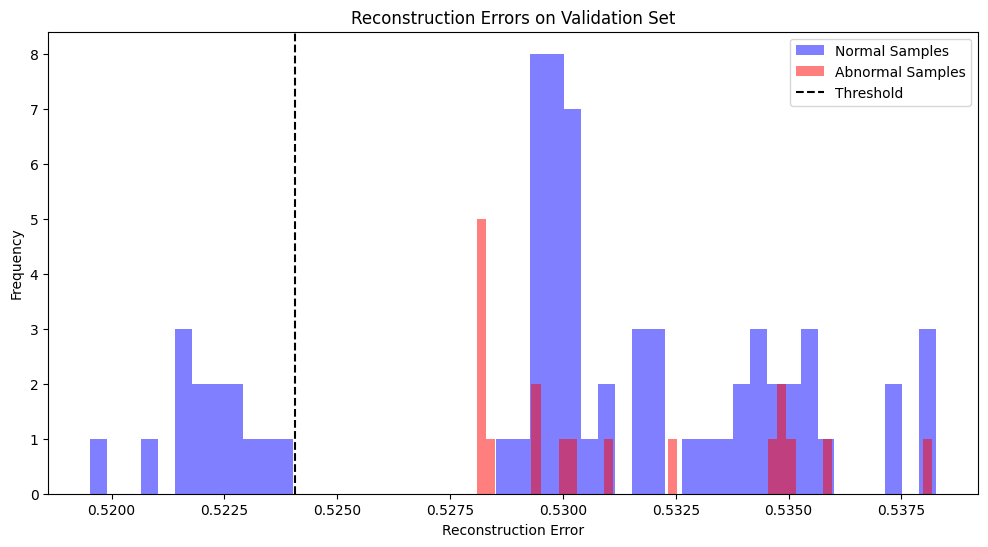

Best Threshold = 0.525579, Best F1 Score = 0.4000
Evaluation on Test Set:
Accuracy = 0.3793103448275862
Precision = 0.25
Recall = 1.0
F1 Score = 0.4
Confusion Matrix:
 [[15 54]
 [ 0 18]]


In [9]:
acc = []
prec = []
rec = []
f1 = []
for fold, (train_idx, val_idx) in enumerate(skf.split(features_original, label)):
    
    print(f"Fold {fold + 1}")
    
   # Get full fold data
    fold_data, fold_labels = features_original[train_idx], label[train_idx]
    val_data, val_labels = features_original[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=np.random.randint(0, 1000))
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=np.random.randint(0, 1000))


    # Train autoencoder on the training fold
    model = train_autoencoder(features_normal, epochs=15, batch_size=64)

    # Add channel dimension to X_val
    X_val = X_val[:, np.newaxis, :]

    # Evaluate on validation fold
    val_normal = X_val[y_val == 0]
    val_abnormal = X_val[y_val == 1]
    val_errors_normal = compute_reconstruction_loss(model, val_normal)
    val_errors_abnormal = compute_reconstruction_loss(model, val_abnormal)
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension    
    val_errors_test = compute_reconstruction_loss(model, X_test)
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)
    acc.append(accuracy_score(y_test, (val_errors_test > threshold).astype(int)))
    prec.append(precision_score(y_test, (val_errors_test > threshold).astype(int)))
    rec.append(recall_score(y_test, (val_errors_test > threshold).astype(int)))
    f1.append(f1_score(y_test, (val_errors_test > threshold).astype(int)))



In [10]:
np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1)

(0.43051201671891326,
 0.25127182379801233,
 0.8456862745098039,
 0.37599512088066334)

# Observation:




Average score:

Accuracy = 0.43051201671891326

Precision = 0.25127182379801233

Recall = 0.8456862745098039

F1 Score = 0.37599512088066334

Best:

Accuracy = 0.8409090909090909

Precision = 0.5454545454545454

Recall = 0.4

F1 Score = 0.4615384615384615

Confusion Matrix:

 [[68  5]

 [ 9  6]]